# Import Thư viện

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.decomposition import PCA
import time
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,\
        accuracy_score,precision_score,recall_score,f1_score


# 1. Loading data 

In [74]:
data = pd.read_csv('Data\loan_Classification.csv')
data.head(10)

C:\Users\YOGA\AppData\Local\Temp\ipykernel_18228\3197910743.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data\loan_Classification.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
6,1069639,1304742,7000,7000,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
7,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
8,1071795,1306957,5600,5600,5600.0,60 months,21.28%,152.39,F,F2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
9,1071570,1306721,5375,5375,5350.0,60 months,12.69%,121.45,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


# 2. Data Understanding & Cleaning

In [75]:
def explore_df(df):
    print("[1] Shape of DataFrame:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    
    print("\n[2] Data Types:")
    print(df.dtypes.to_string())
    
    print("\n[3] DataFrame Info:")
    print("-" * 60)
    df.info()
    print("-" * 60)
    
    print("\n[4] Null Values (isnull().sum()):")
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("    No missing values.")
    else:
        print(null_counts[null_counts > 0].sort_values(ascending=False).to_string())

    print("\n[5] Number of Duplicated Rows:")
    print(f"{df.duplicated().sum()} duplicated rows")
explore_df(data)

[1] Shape of DataFrame:
Rows: 39717, Columns: 111

[2] Data Types:
id                                  int64
member_id                           int64
loan_amnt                           int64
funded_amnt                         int64
funded_amnt_inv                   float64
term                               object
int_rate                           object
installment                       float64
grade                              object
sub_grade                          object
emp_title                          object
emp_length                         object
home_ownership                     object
annual_inc                        float64
verification_status                object
issue_d                            object
loan_status                        object
pymnt_plan                         object
url                                object
desc                               object
purpose                            object
title                              object
zip_code 

In [76]:
def column_summary(df, cat_th=5, car_th=10):

    cat_cols = [col for col in df.columns if df[col].dtype == "O"]
    num_cols = [col for col in df.columns if df[col].dtype != "O"]
    
    num_but_cat = [col for col in num_cols if df[col].nunique() < cat_th]
    cat_but_car = [col for col in cat_cols if df[col].nunique() > car_th]
    
    # Loại bỏ num_but_cat khỏi num_cols
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    # Loại bỏ cat_but_car khỏi cat_cols
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    print(f"# of Categorical Columns: {len(cat_cols)} (Numerical but categorical: {len(num_but_cat)})")
    print(f"# of Numerical Columns: {len(num_cols)}")
    print(f"# of Categorical but Cardinal Columns: {len(cat_but_car)}\n")
    
    print("Categorical Columns:", cat_cols)
    print("Numerical but Categorical Columns:", num_but_cat)
    print("Numerical Columns:", num_cols)
    print("Categorical but Cardinal Columns:", cat_but_car)
    
    return {
        "categorical_cols": cat_cols,
        "numerical_cols": num_cols,
        "num_but_cat": num_but_cat,
        "cat_but_car": cat_but_car
    }
summary = column_summary(data)


# of Categorical Columns: 9 (Numerical but categorical: 61)
# of Numerical Columns: 26
# of Categorical but Cardinal Columns: 15

Categorical Columns: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type']
Numerical but Categorical Columns: ['collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent

In [77]:
def check_feature_missing_sum(data):
    missing_feature = 0
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            missing_feature += 1
    print(f"Number of features with missing values: {missing_feature}")
check_feature_missing_sum(data)

Number of features with missing values: 68


**Initial observations**

- The dataset contains 39,717 observations with 110 feature variables and one target variable, `loan_status`.

- Among the 110 features, 68 contain missing values. Handling these missing values properly is crucial to avoid significant information loss during analysis.

- The dataset includes 70 categorical features and 24 features with data type "object" (string). To use these variables in traditional models such as Logistic Regression, appropriate preprocessing and encoding are required.

## Data Cleaning

**Check Entity Features**

In [78]:
print(f"id unique values: {data['id'].nunique()}")
print(f"member_id unique values: {data['member_id'].nunique()}")

id unique values: 39717
member_id unique values: 39717


**Observation**

The features `id` and `member_id` have as many unique values as the number of records, indicating that they are entity identifiers. Moreover, the dataset is not time-series in nature, as each record represents a distinct and independent individual. Therefore, these entity features can be dropped since they do not provide any useful information for the machine learning model.

**Check Label Leaking Features** 

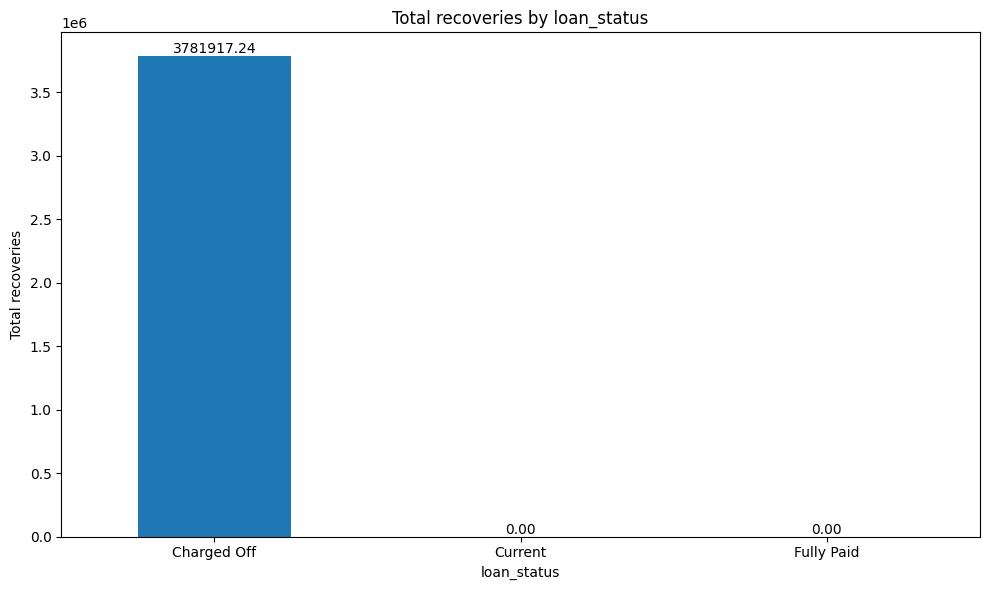

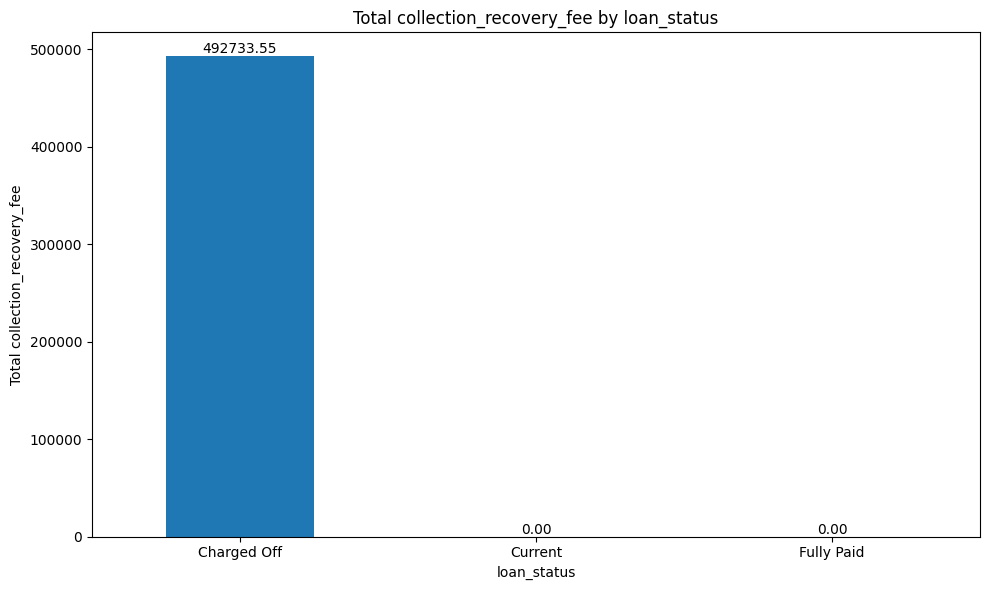

In [79]:
def plot_grouped_bar_sum(df, group_col, value_col, title=None):

    plt.figure(figsize=(10, 6))
    total_values = df.groupby(group_col)[value_col].sum()
    bars = total_values.plot(kind='bar')

    for bar, value in zip(bars.patches, total_values):
        bars.annotate(f'{value:.2f}',
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='bottom', fontsize=10)

    plt.title(title or f'Total {value_col} by {group_col}')
    plt.xlabel(group_col)
    plt.ylabel(f'Total {value_col}')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
plot_grouped_bar_sum(data, group_col='loan_status', value_col='recoveries', title='Total recoveries by loan_status')
plot_grouped_bar_sum(data, group_col='loan_status', value_col='collection_recovery_fee', title='Total collection_recovery_fee by loan_status')


**Observation**

From the two bar charts, we can observe that the features `recoveries` and `collection_recovery_fee` only have non-zero values for the `Charged Off` label. This aligns with their meanings: "post charge-off gross recovery" and "post charge-off collection fee." It suggests that these features are only recorded after a loan has been classified as `Charged Off`. Therefore, knowing their values would essentially reveal the target label, making predictions meaningless. These features must be removed due to the issue of label leakage.

**Check meaningless features.**

In [80]:
cat_cols = summary['categorical_cols']
print(f"# of Unique values of Categorical features:\n{data[cat_cols].nunique()}")

# of Unique values of Categorical features:
term                   2
grade                  7
home_ownership         5
verification_status    3
loan_status            3
pymnt_plan             1
initial_list_status    1
next_pymnt_d           2
application_type       1
dtype: int64


**Observations**

It can be observed that some features contain only a single unique value. This indicates that they provide little to no useful information for the model. Therefore, these features can be safely removed from the dataset.

**Check Irrelevant features**

In [81]:
print(data['desc'].value_counts())

desc
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           210
Debt Consolidation                                                                                                                                                                  

In [82]:
print(data['title'].value_counts())

title
Debt Consolidation                  2184
Debt Consolidation Loan             1729
Personal Loan                        659
Consolidation                        517
debt consolidation                   505
                                    ... 
your rate is better than my rate       1
Concession Trailer                     1
gregs                                  1
EZover                                 1
JAL Loan                               1
Name: count, Length: 19615, dtype: int64


In [83]:
print(data['url'].value_counts())

url
https://lendingclub.com/browse/loanDetail.action?loan_id=1077501    1
https://lendingclub.com/browse/loanDetail.action?loan_id=568534     1
https://lendingclub.com/browse/loanDetail.action?loan_id=568659     1
https://lendingclub.com/browse/loanDetail.action?loan_id=567165     1
https://lendingclub.com/browse/loanDetail.action?loan_id=568531     1
                                                                   ..
https://lendingclub.com/browse/loanDetail.action?loan_id=785667     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785659     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785630     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785626     1
https://lendingclub.com/browse/loanDetail.action?loan_id=87023      1
Name: count, Length: 39717, dtype: int64


**Observations**

The features `desc` and `title` describe the reason and context of the loan request. These fields often contain personal justifications written differently by each individual, making them unsuitable for the intended analysis and modeling. Additionally, the `purpose` feature already provides similar information in a processed and standardized form, so `desc` and `title` can be removed. Furthermore, the `url` feature simply stores links to customer data and can also be discarded.

In [84]:
def Data_Cleaning(df, column):
    df = df.drop(columns=column, axis=1)
    for c in df.columns:
        if df[c].nunique() < 2:
            df = df.drop(columns=c, axis=1)
    return df
data = Data_Cleaning(data.copy(),['id', 'member_id', 'desc', 'title', 'url','recoveries','collection_recovery_fee'])

## Data type conversion

**From object to float**

In [85]:
print(data['int_rate'].head())
print(data['revol_util'].head())

0    10.65%
1    15.27%
2    15.96%
3    13.49%
4    12.69%
Name: int_rate, dtype: object
0    83.70%
1     9.40%
2    98.50%
3       21%
4    53.90%
Name: revol_util, dtype: object


**Observations**

Both variables `int_rate` and `revol_util` have data type object representing percentage so convert this type to float to perform for the model

In [86]:
def convert_percent_to_float(df, columns):
    for column in columns:
        df[column] = df[column].str.rstrip('%').astype(float) / 100.0
    return df
data = convert_percent_to_float(data, ['int_rate', 'revol_util'])

**From object to datetime**

In [87]:
print(data[['earliest_cr_line', 'last_credit_pull_d','issue_d', 'last_pymnt_d']].head())


  earliest_cr_line last_credit_pull_d issue_d last_pymnt_d
0           Jan-85             May-16  Dec-11       Jan-15
1           Apr-99             Sep-13  Dec-11       Apr-13
2           Nov-01             May-16  Dec-11       Jun-14
3           Feb-96             Apr-16  Dec-11       Jan-15
4           Jan-96             May-16  Dec-11       May-16


**Observations**

The features `earliest_cr_line`, `last_pymnt_d`, `last_credit_pull_d`, and `issue_d` contain datetime values in the format MM-YY. However, they are currently stored as strings (object type), and will therefore be converted to the appropriate datetime data type to ensure correct temporal processing

In [88]:
def convert_month_year_columns(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format='%b-%y', errors='coerce')
        df[col] = df[col].dt.to_period('M')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df = df.drop(columns=[col], axis=1)
    return df
cols = ['earliest_cr_line', 'last_credit_pull_d', 'issue_d', 'last_pymnt_d']
data = convert_month_year_columns(data.copy(), cols)
data[['earliest_cr_line_year', 'earliest_cr_line_month', 
            'last_credit_pull_d_year', 'last_credit_pull_d_month',
            'issue_d_year', 'issue_d_month', 
            'last_pymnt_d_year', 'last_pymnt_d_month']].head()


,earliest_cr_line_year,earliest_cr_line_month,last_credit_pull_d_year,last_credit_pull_d_month,issue_d_year,issue_d_month,last_pymnt_d_year,last_pymnt_d_month
0,1985,1,2016,5,2011,12,2015,1
1,1999,4,2013,9,2011,12,2013,4
2,2001,11,2016,5,2011,12,2014,6
3,1996,2,2016,4,2011,12,2015,1
4,1996,1,2016,5,2011,12,2016,5


### **Handling categorical variables**

In [89]:
print(data['term'].value_counts())

term
36 months    29096
60 months    10621
Name: count, dtype: int64


In [90]:
print(data['grade'].value_counts())

grade
B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: count, dtype: int64


In [91]:
print(data['verification_status'].value_counts())

verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: count, dtype: int64


In [92]:
print(data['emp_length'].value_counts())

emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: count, dtype: int64


In [93]:
print(data['sub_grade'].value_counts())

sub_grade
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: count, dtype: int64


In [94]:
print(data['home_ownership'].value_counts())

home_ownership
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: count, dtype: int64


In [95]:
print(data['emp_title'].value_counts())

emp_title
US Army                              134
Bank of America                      109
IBM                                   66
AT&T                                  59
Kaiser Permanente                     56
                                    ... 
Community College of Philadelphia      1
AMEC                                   1
lee county sheriff                     1
Bacon County Board of Education        1
Evergreen Center                       1
Name: count, Length: 28820, dtype: int64


In [96]:
print(data['purpose'].value_counts())

purpose
debt_consolidation    18641
credit_card            5130
other                  3993
home_improvement       2976
major_purchase         2187
small_business         1828
car                    1549
wedding                 947
medical                 693
moving                  583
vacation                381
house                   381
educational             325
renewable_energy        103
Name: count, dtype: int64


In [97]:
print(data['next_pymnt_d'].value_counts())

next_pymnt_d
Jun-16    1125
Jul-16      15
Name: count, dtype: int64


In [98]:
print(data['addr_state'].value_counts())

addr_state
CA    7099
NY    3812
FL    2866
TX    2727
NJ    1850
IL    1525
PA    1517
VA    1407
GA    1398
MA    1340
OH    1223
MD    1049
AZ     879
WA     840
CO     792
NC     788
CT     751
MI     720
MO     686
MN     615
NV     497
SC     472
WI     460
AL     452
OR     451
LA     436
KY     325
OK     299
KS     271
UT     258
AR     245
DC     214
RI     198
NM     189
WV     177
HI     174
NH     171
DE     114
MT      85
WY      83
AK      80
SD      64
VT      54
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: count, dtype: int64


In [99]:
print(data['zip_code'].value_counts())

zip_code
100xx    597
945xx    545
112xx    516
606xx    503
070xx    473
        ... 
381xx      1
378xx      1
739xx      1
396xx      1
469xx      1
Name: count, Length: 823, dtype: int64


**Observations**

- The feature `term` has 2 unique values, representing The number of payments on the loan. Values ​​are in months and can be either 36 or 60.
so we encode 0 and 1 for these 2 values.

- The features `grade` and `sub_grade` both represent credit grading scales, with `sub_grade` providing a more granular and well-defined classification. Upon examination, `sub_grade` offers clearer distinctions between categories compared to `grade`. Therefore, we will retain `sub_grade`, apply label encoding to it, and remove the more redundant `grade` feature.

- The feature `verification_status` contains three distinct categorical values that do not follow any inherent order or hierarchy. Therefore, one-hot encoding is an appropriate method to transform this feature for use in modeling.

- The `emp_length` feature reflects the number of years of employment and exhibits a clear ordinal structure. Hence, label encoding will be applied, where a value of 0 corresponds to less than one year of experience, and higher integers represent longer employment durations.

- Although `emp_title` may offer useful occupational information, its extremely high number of unique entries (28,820) poses challenges for effective grouping and standardization. Considering the limited added value relative to the effort required, this feature has been dropped to simplify the modeling pipeline.

- The `purpose` feature reflects the reason a customer applies for a loan. Although it contains 13 unique categories, the distribution is highly imbalanced, with the majority of entries falling under the `debt_consolidation` category. While one-hot encoding is a viable option, it may introduce unnecessary complexity for traditional machine learning models. To simplify the feature space and reduce computational overhead, we recode this variable into a binary format: `debt_consolidation` (encoded as 1) and all other purposes grouped under `not_debt_consolidation` (encoded as 0).

- With the feature `home_ownership`, the number of different values ​​is 5, but 2 values, `RENT` and `MORETGAGE`, make up the majority of the data, while the remaining 3 values ​​make up very little, so to reduce the calculation cost as well as simplify the problem, we will group the 3 values ​​with that small proportion into a new group.

- The `next_pymnt_d` feature indicates the customer's next scheduled payment date. Missing values in this feature suggest that no upcoming payment has been scheduled. To capture this information effectively, we encode missing values as `Unknown` to represent an unscheduled payment. Subsequently, we simplify this feature into a binary variable: `scheduled payment` (encoded as 1) and `unscheduled payment` (encoded as 0)

- "The features `zip_code` and `addr_state` both provide geographic information about the applicant’s location. To avoid redundancy and reduce dimensionality, we choose to retain the `addr_state` feature and discard `zip_code`. Additionally, `addr_state` can be further grouped into broader regional categories to enhance interpretability and modeling efficiency

**In summary**

- Remove: `grade`, `emp_title` and `zip_code`.

- Label_encoding: `term`, `sub_grade`, `emp_length`, `purpose` and `next_pymnt_d`.

- One-hot encoding: `verification_status`, `home_ownership`, `addr_state`

#### Remove

In [100]:
def remove_features(df, features):
    for feature in features:
            df = df.drop(columns=feature, axis=1)
    return df
data = remove_features(data.copy(), ['emp_title', 'zip_code','grade'])

#### Label encoding

In [101]:
def label_encoding(df):
    """
    Tiền xử lý các cột:
    - purpose: binary hóa (1 nếu debt_consolidation, else 0)
    - next_pymnt_d: binary hóa (1 nếu là Dec-16 hoặc Jan-17, else 0)
    - term: '36 months' → 0, '60 months' → 1
    - emp_length: '< 1 year' → 0, ..., '10+ years' → 10
    - sub_grade: thứ tự từ A1 (0) đến G5 (34)
    """
    # Binary encode 'purpose'
    df['purpose'] = df['purpose'].apply(lambda x: 1 if x == 'debt_consolidation' else 0)

    # Binary encode 'next_pymnt_d'
    df['next_pymnt_d'] = df['next_pymnt_d'].apply(lambda x: 1 if x in ['Jun-16', 'Jul-16'] else 0)

    # Encode 'term'
    df['term'] = df['term'].map({' 36 months': 0, ' 60 months': 1})

    # Encode 'emp_length'
    emp_order = {
        '< 1 year': 0,
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10
    }
    df['emp_length'] = df['emp_length'].map(emp_order).fillna(0).astype(int)

    # Encode 'sub_grade'
    subgrade_order = ['A1','A2','A3','A4','A5',
                      'B1','B2','B3','B4','B5',
                      'C1','C2','C3','C4','C5',
                      'D1','D2','D3','D4','D5',
                      'E1','E2','E3','E4','E5',
                      'F1','F2','F3','F4','F5',
                      'G1','G2','G3','G4','G5']
    subgrade_map = {grade: i for i, grade in enumerate(subgrade_order)}
    df['sub_grade'] = df['sub_grade'].map(subgrade_map)

    return df
data = label_encoding(data.copy())

#### One-hot encoding

In [102]:
# Group data addr_state
def create_state_region_map():
    region_map = {}

    for state in ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']:
        region_map[state] = 'Northeast'

    for state in ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']:
        region_map[state] = 'Midwest'

    for state in ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA',
                  'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']:
        region_map[state] = 'South'

    for state in ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']:
        region_map[state] = 'West'

    return region_map
# Gán theo map
region_map = create_state_region_map()
data['addr_region'] = data['addr_state'].map(region_map).fillna('Unknown')
data = data.drop(columns='addr_state', axis=1)

In [103]:
# Group  home_ownership
def process_home_ownership(value):
    if value in ['OWN', 'OTHER', 'NONE']:
        return 'OTHER_new'
    else:
        return value
data['home_ownership'] = data['home_ownership'].apply(process_home_ownership)

In [104]:
def get_dummies_custom(df):
    columns_to_encode = ['verification_status', 'home_ownership', 'addr_region']
    
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=int)
    return df_encoded
data = get_dummies_custom(data.copy())


In [105]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,annual_inc,loan_status,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_MORTGAGE,home_ownership_OTHER_new,home_ownership_RENT,addr_region_Midwest,addr_region_Northeast,addr_region_South,addr_region_West
0,5000,5000,4975.0,0,0.1065,162.87,6,10,24000.0,Fully Paid,...,0,0,1,0,0,1,0,0,0,1
1,2500,2500,2500.0,1,0.1527,59.83,13,0,30000.0,Charged Off,...,0,1,0,0,0,1,0,0,1,0
2,2400,2400,2400.0,0,0.1596,84.33,14,10,12252.0,Fully Paid,...,1,0,0,0,0,1,1,0,0,0
3,10000,10000,10000.0,0,0.1349,339.31,10,10,49200.0,Fully Paid,...,0,1,0,0,0,1,0,0,0,1
4,3000,3000,3000.0,1,0.1269,67.79,9,1,80000.0,Current,...,0,1,0,0,0,1,0,0,0,1


### handling Missing values

In [106]:
print(' MISSING VALUES '.center(70, '-'))
print(data.isnull().sum())

--------------------------- MISSING VALUES ---------------------------
loan_amnt                                  0
funded_amnt                                0
funded_amnt_inv                            0
term                                       0
int_rate                                   0
installment                                0
sub_grade                                  0
emp_length                                 0
annual_inc                                 0
loan_status                                0
purpose                                    0
dti                                        0
delinq_2yrs                                0
inq_last_6mths                             0
mths_since_last_delinq                 25682
mths_since_last_record                 36931
open_acc                                   0
pub_rec                                    0
revol_bal                                  0
revol_util                                50
total_acc                    

In [107]:
def show_missing_values(df):
    total_rows = len(df)
    missing_series = df.isnull().sum()
    missing = missing_series[missing_series > 0]

    if missing.empty:
        print("Không có missing values nào trong DataFrame.")
        return

    result = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': (missing / total_rows * 100).round(2)
    }).sort_values(by='Missing Count', ascending=False)

    print("--------------------------- MISSING VALUES ---------------------------")
    print(result)
show_missing_values(data)


--------------------------- MISSING VALUES ---------------------------
                        Missing Count  Missing %
mths_since_last_record          36931      92.99
mths_since_last_delinq          25682      64.66
pub_rec_bankruptcies              697       1.75
revol_util                         50       0.13


**Observations**

- The features `mths_since_last_record` and `mths_since_last_delinq` have **92.99%** and **64.66%** missing data, respectively. Additionally, since both are numerical features, we cannot handle them the same way we did with categorical features earlier. Therefore, we can choose to remove these features. 

-  The features `revol_util`, and `pub_rec_bankruptcies` have relatively few missing values — approximately 0.13%, 1.75%, respectively — so we can drop those observations without significantly affecting the overall data distribution.

In [108]:
data = data.drop(columns=['mths_since_last_delinq', 'mths_since_last_record'], axis=1)
data = data.dropna()

In [109]:
show_missing_values(data)

Không có missing values nào trong DataFrame.


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38970 entries, 0 to 39680
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            38970 non-null  int64  
 1   funded_amnt                          38970 non-null  int64  
 2   funded_amnt_inv                      38970 non-null  float64
 3   term                                 38970 non-null  int64  
 4   int_rate                             38970 non-null  float64
 5   installment                          38970 non-null  float64
 6   sub_grade                            38970 non-null  int64  
 7   emp_length                           38970 non-null  int32  
 8   annual_inc                           38970 non-null  float64
 9   loan_status                          38970 non-null  object 
 10  purpose                              38970 non-null  int64  
 11  dti                              

**Observations**

- Following comprehensive preprocessing, the dataset is now free from missing values and duplicate entries. Irrelevant features have been eliminated, categorical and temporal variables have been encoded appropriately, and outliers have been addressed. The dataset is therefore ready to be utilized for further analysis and model development

# 3. EDA

**Check distribution of the target variables `loan_status`**

Phân phối biến mục tiêu: 'loan_status'
             Count  Percent (%)
loan_status                    
Fully Paid   32337        82.98
Charged Off   5493        14.10
Current       1140         2.93


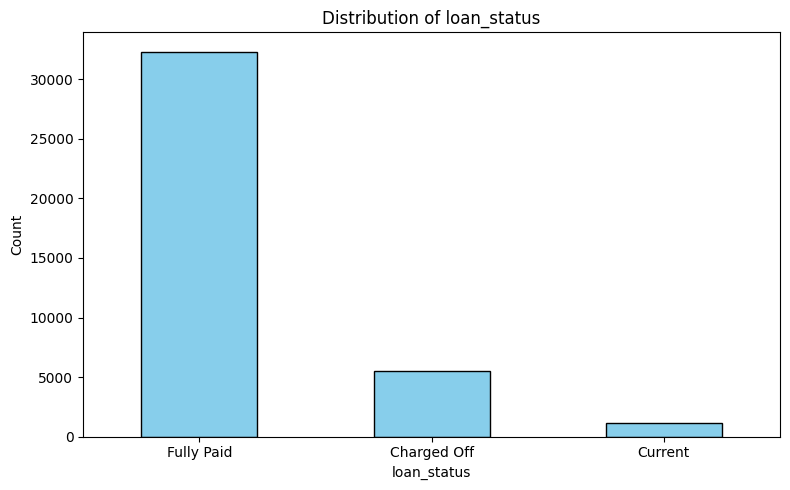

In [111]:
def check_target_distribution(df, target_col='loan_status'):   
    print(f"Phân phối biến mục tiêu: '{target_col}'")

    value_counts = df[target_col].value_counts(dropna=False)
    percentages = (value_counts / len(df) * 100).round(2)

    # Gộp vào 1 bảng
    result = pd.DataFrame({
        'Count': value_counts,
        'Percent (%)': percentages
    })

    print(result)

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 5))
    value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

check_target_distribution(data, target_col='loan_status')

**Observations**

- The target variable loan_status contains three categories::

    * `Fully Paid`: the borrower has paid in full according to the terms

    * `Current`: The borrower is currently making timely payments and is actively servicing the loan.

    *  `Charged Off`: The borrower has defaulted for an extended period, and the loan has been

 To align with the objective of developing a model that predicts loan approval, we categorize borrowers demonstrating responsible repayment behavior (Fully Paid and Current) as Accept (loan-worthy), and those with a history of default (Charged Off) as Reject (not loan-worthy).

Accordingly, we encode:

    `Accept` as 1

    `Reject` as 0

**Class Imbalance Consideration**

An imbalance exists between the two resulting classes, which may lead the model to favor the majority class. Initially, we will proceed with training baseline models to evaluate the extent of this issue. If class imbalance significantly affects model performance, appropriate resampling or reweighting techniques will be applied. Otherwise, no additional intervention will be necessary

In [112]:
data['loan_status'] = data['loan_status'].apply(lambda x:1 if x == 'Fully Paid' or x == 'Current' else 0)

In [113]:
X = data.drop(columns=['loan_status'], axis=1)
y = data['loan_status']

In [114]:
X.shape, y.shape

((38970, 46), (38970,))

## Correlations between features and targget variable 

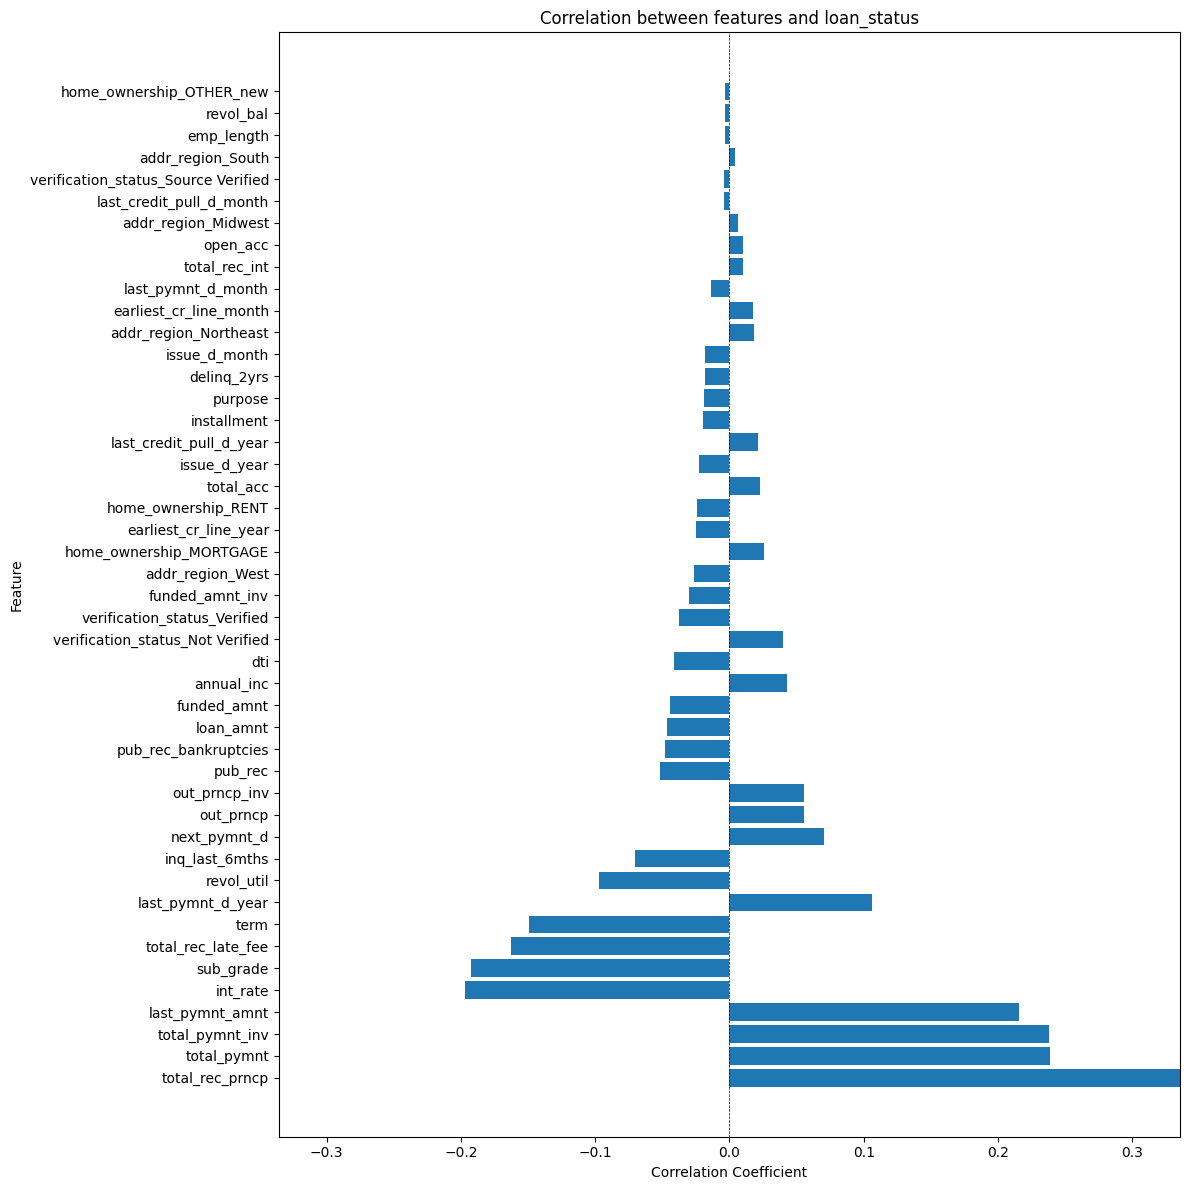

In [115]:

correlation_matrix = data.corr()
correlation_coef = correlation_matrix['loan_status'].drop('loan_status')
features = X.columns

loan_status_correlations = pd.DataFrame({
    'Feature': features,
    'Correlation': correlation_coef
})

# Select correlations with 'loan_status'
loan_status_correlations['Abs Correlation'] = np.abs(
    loan_status_correlations['Correlation'])
loan_status_correlations_sorted = loan_status_correlations.sort_values(
    by='Abs Correlation', ascending=False)

# Plot the correlations
plt.figure(figsize=(12, 12))
plt.barh(loan_status_correlations_sorted['Feature'],
         loan_status_correlations_sorted['Correlation'])
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.title('Correlation between features and loan_status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')

# Set symmetric x-axis limits
max_corr = loan_status_correlations_sorted['Correlation'].abs().max()
plt.xlim(-max_corr, max_corr)

plt.tight_layout()
plt.show()

**Observations**

- There is no feature that has a strong correlation (>0.5) with the target variable `loan_status`.

- Although there are 46 features, only about 10 features show a notable correlation with the target variable `loan_status`, including: `total_rec_prncp`, `total_pymnt`, `total_pymnt_inv`, `last_pymnt_amnt`, `last_pymnt_d_year`, `int_rate`, `sub_grade`, `total_rec_late_fee`, `term`, `revol_util`.

⇒ We can predict that models might achieve similar performance using only these approximately 10 features (or slightly more or fewer) compared to using all 46 features. Based on this, it may be possible to design a simpler model with nearly equivalent effectiveness.

##  Univariate Analysis

In [116]:
numeric_df = data.select_dtypes(include=[np.number])

numeric_df = numeric_df.drop(columns=['loan_status'])
summary_2 = column_summary(
    numeric_df, cat_th=5, car_th=10)

# of Categorical Columns: 0 (Numerical but categorical: 14)
# of Numerical Columns: 32
# of Categorical but Cardinal Columns: 0

Categorical Columns: []
Numerical but Categorical Columns: ['term', 'purpose', 'next_pymnt_d', 'pub_rec_bankruptcies', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'home_ownership_MORTGAGE', 'home_ownership_OTHER_new', 'home_ownership_RENT', 'addr_region_Midwest', 'addr_region_Northeast', 'addr_region_South', 'addr_region_West']
Numerical Columns: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'earliest_cr_line_year', 'earliest_cr_line_month', 'last_credit_pull_d_year', 'last_credit_pull_d_m

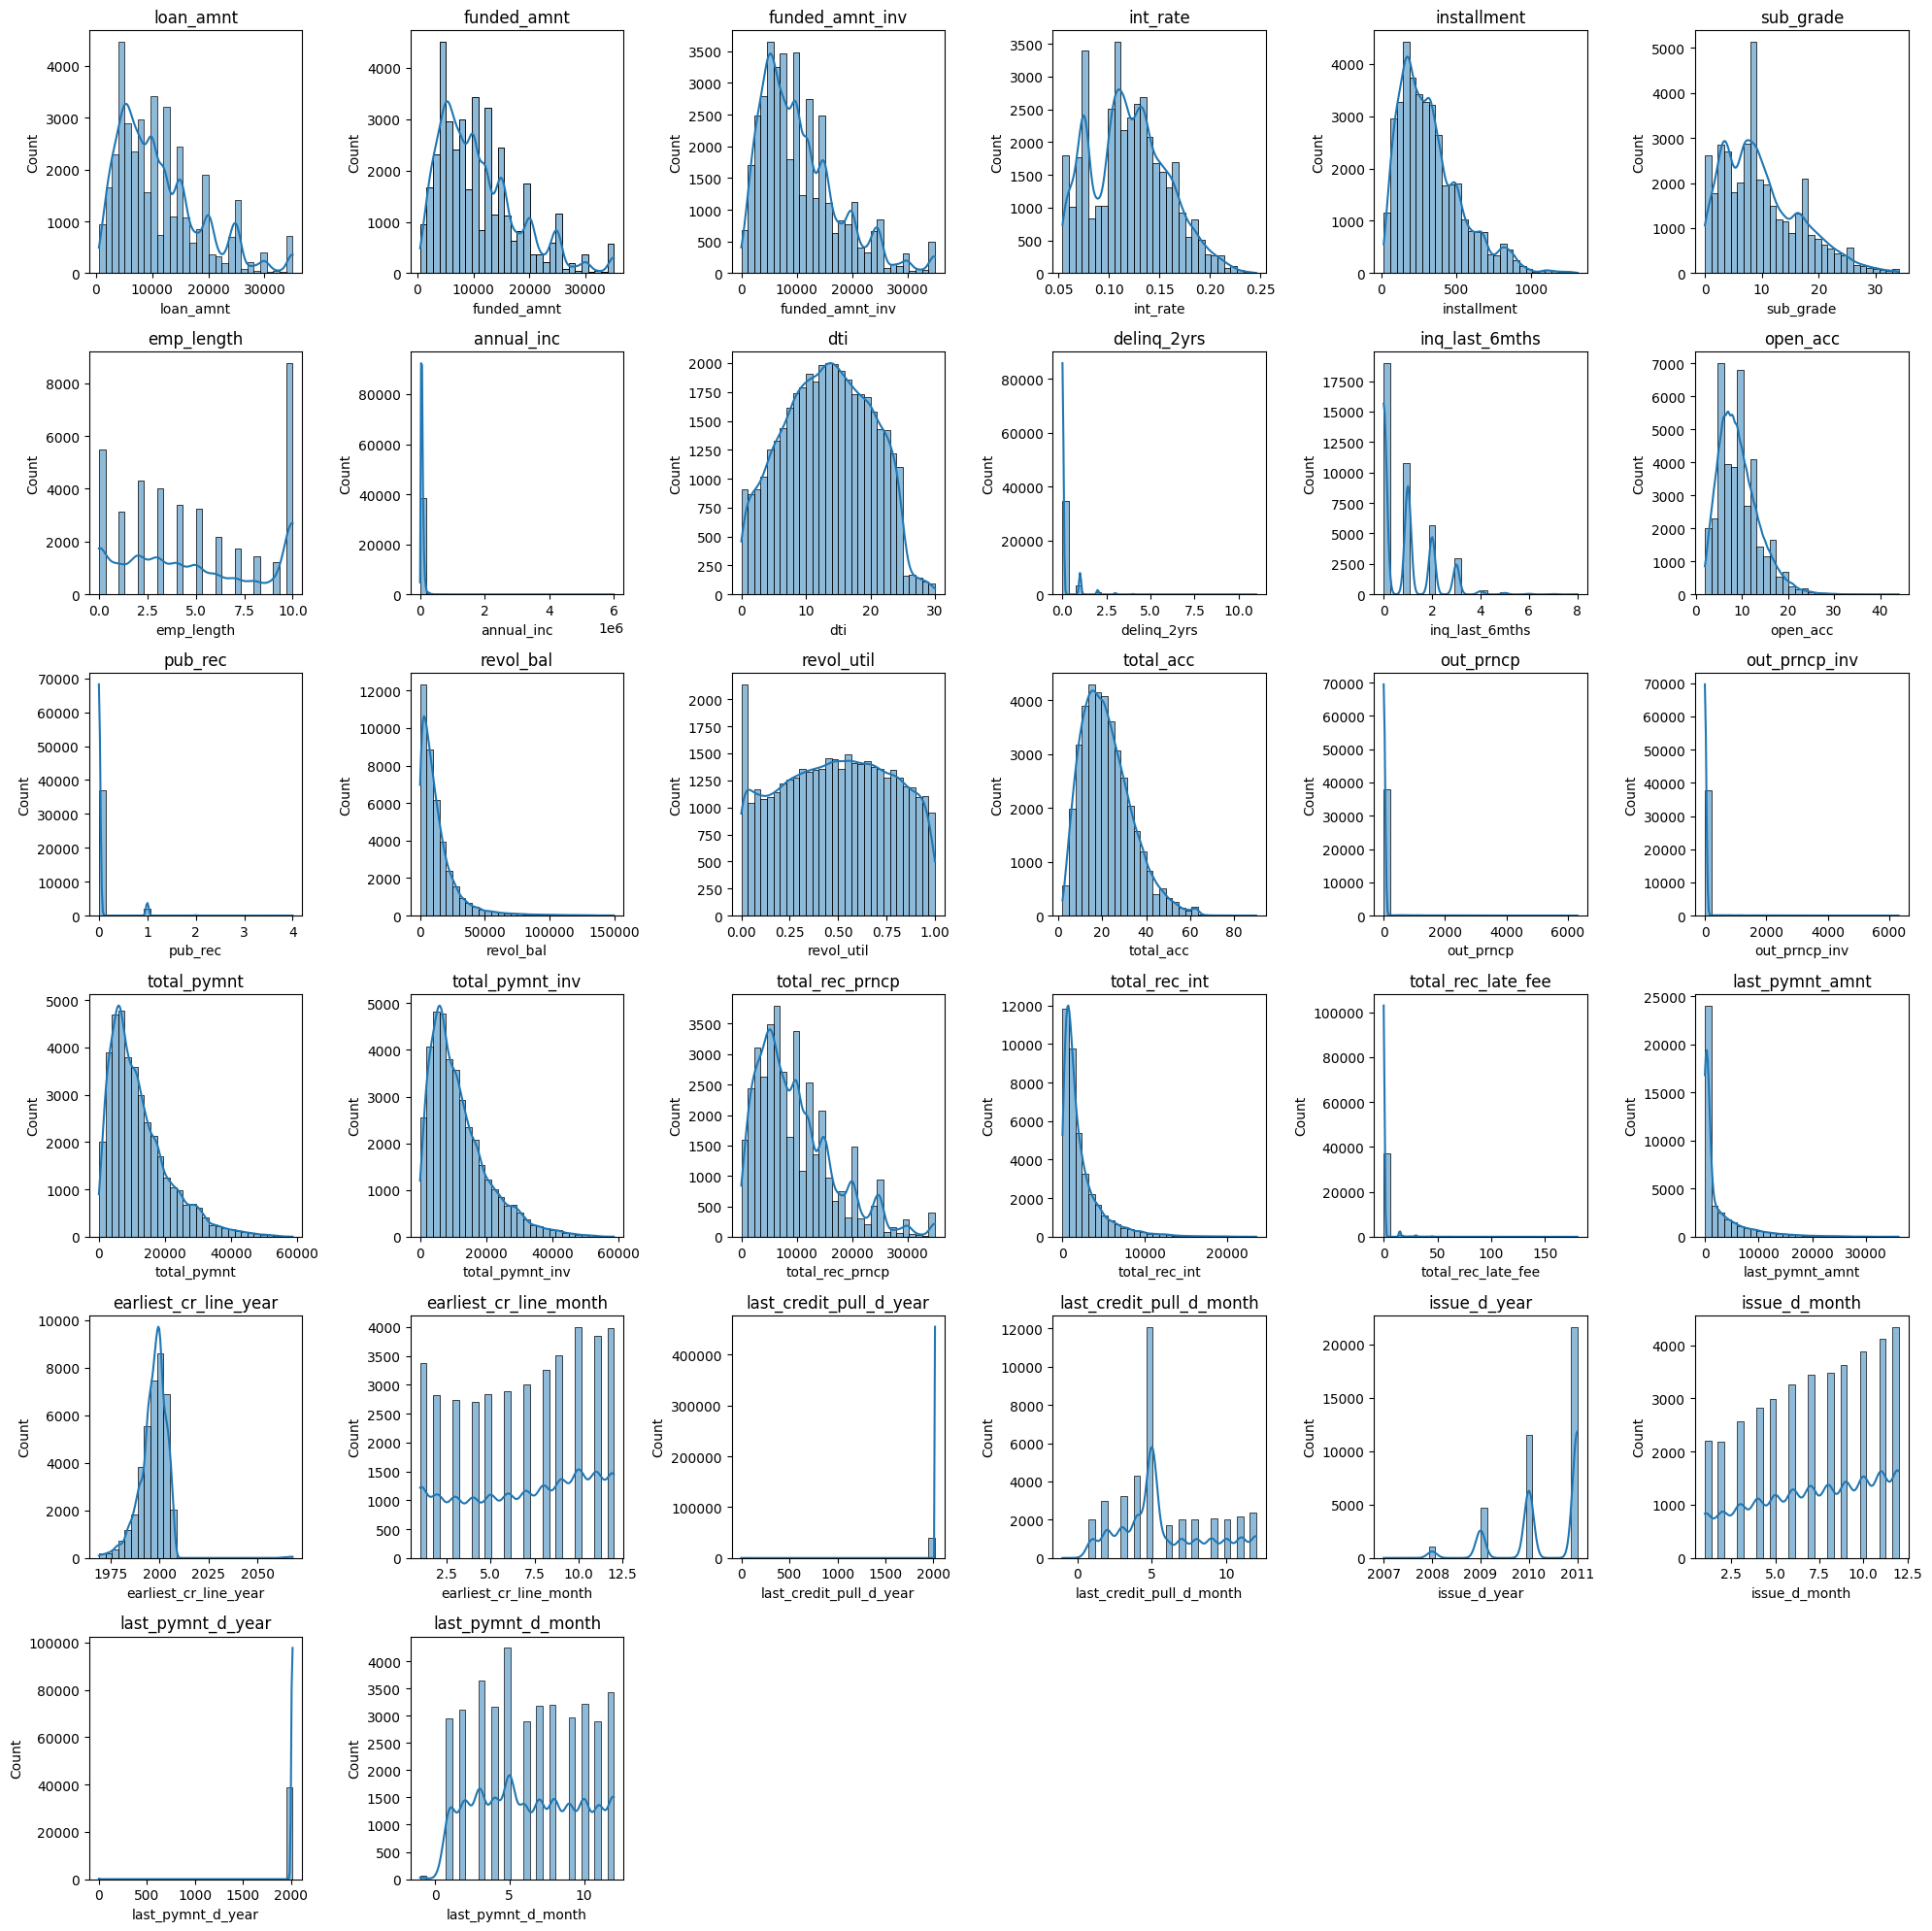

In [117]:
num_cols = summary_2['numerical_cols']

def plot_distributions(df, columns, cols=4, figsize=(20, 20), kind='hist'):
    rows = -(-len(columns) // cols)  # làm tròn lên
    plt.figure(figsize=figsize)

    for i, col in enumerate(columns, 1):
        plt.subplot(rows, cols, i)
        
        if kind == 'hist':
            sns.histplot(df[col], kde=True, bins=30)
        elif kind == 'boxplot':
            sns.boxplot(x=df[col])
        else:
            raise ValueError("kind must be 'hist' or 'boxplot'")
        
        plt.title(col)
        plt.tight_layout()

    plt.show()
plot_distributions(data, num_cols, cols=6, figsize=(20, 20), kind='hist')


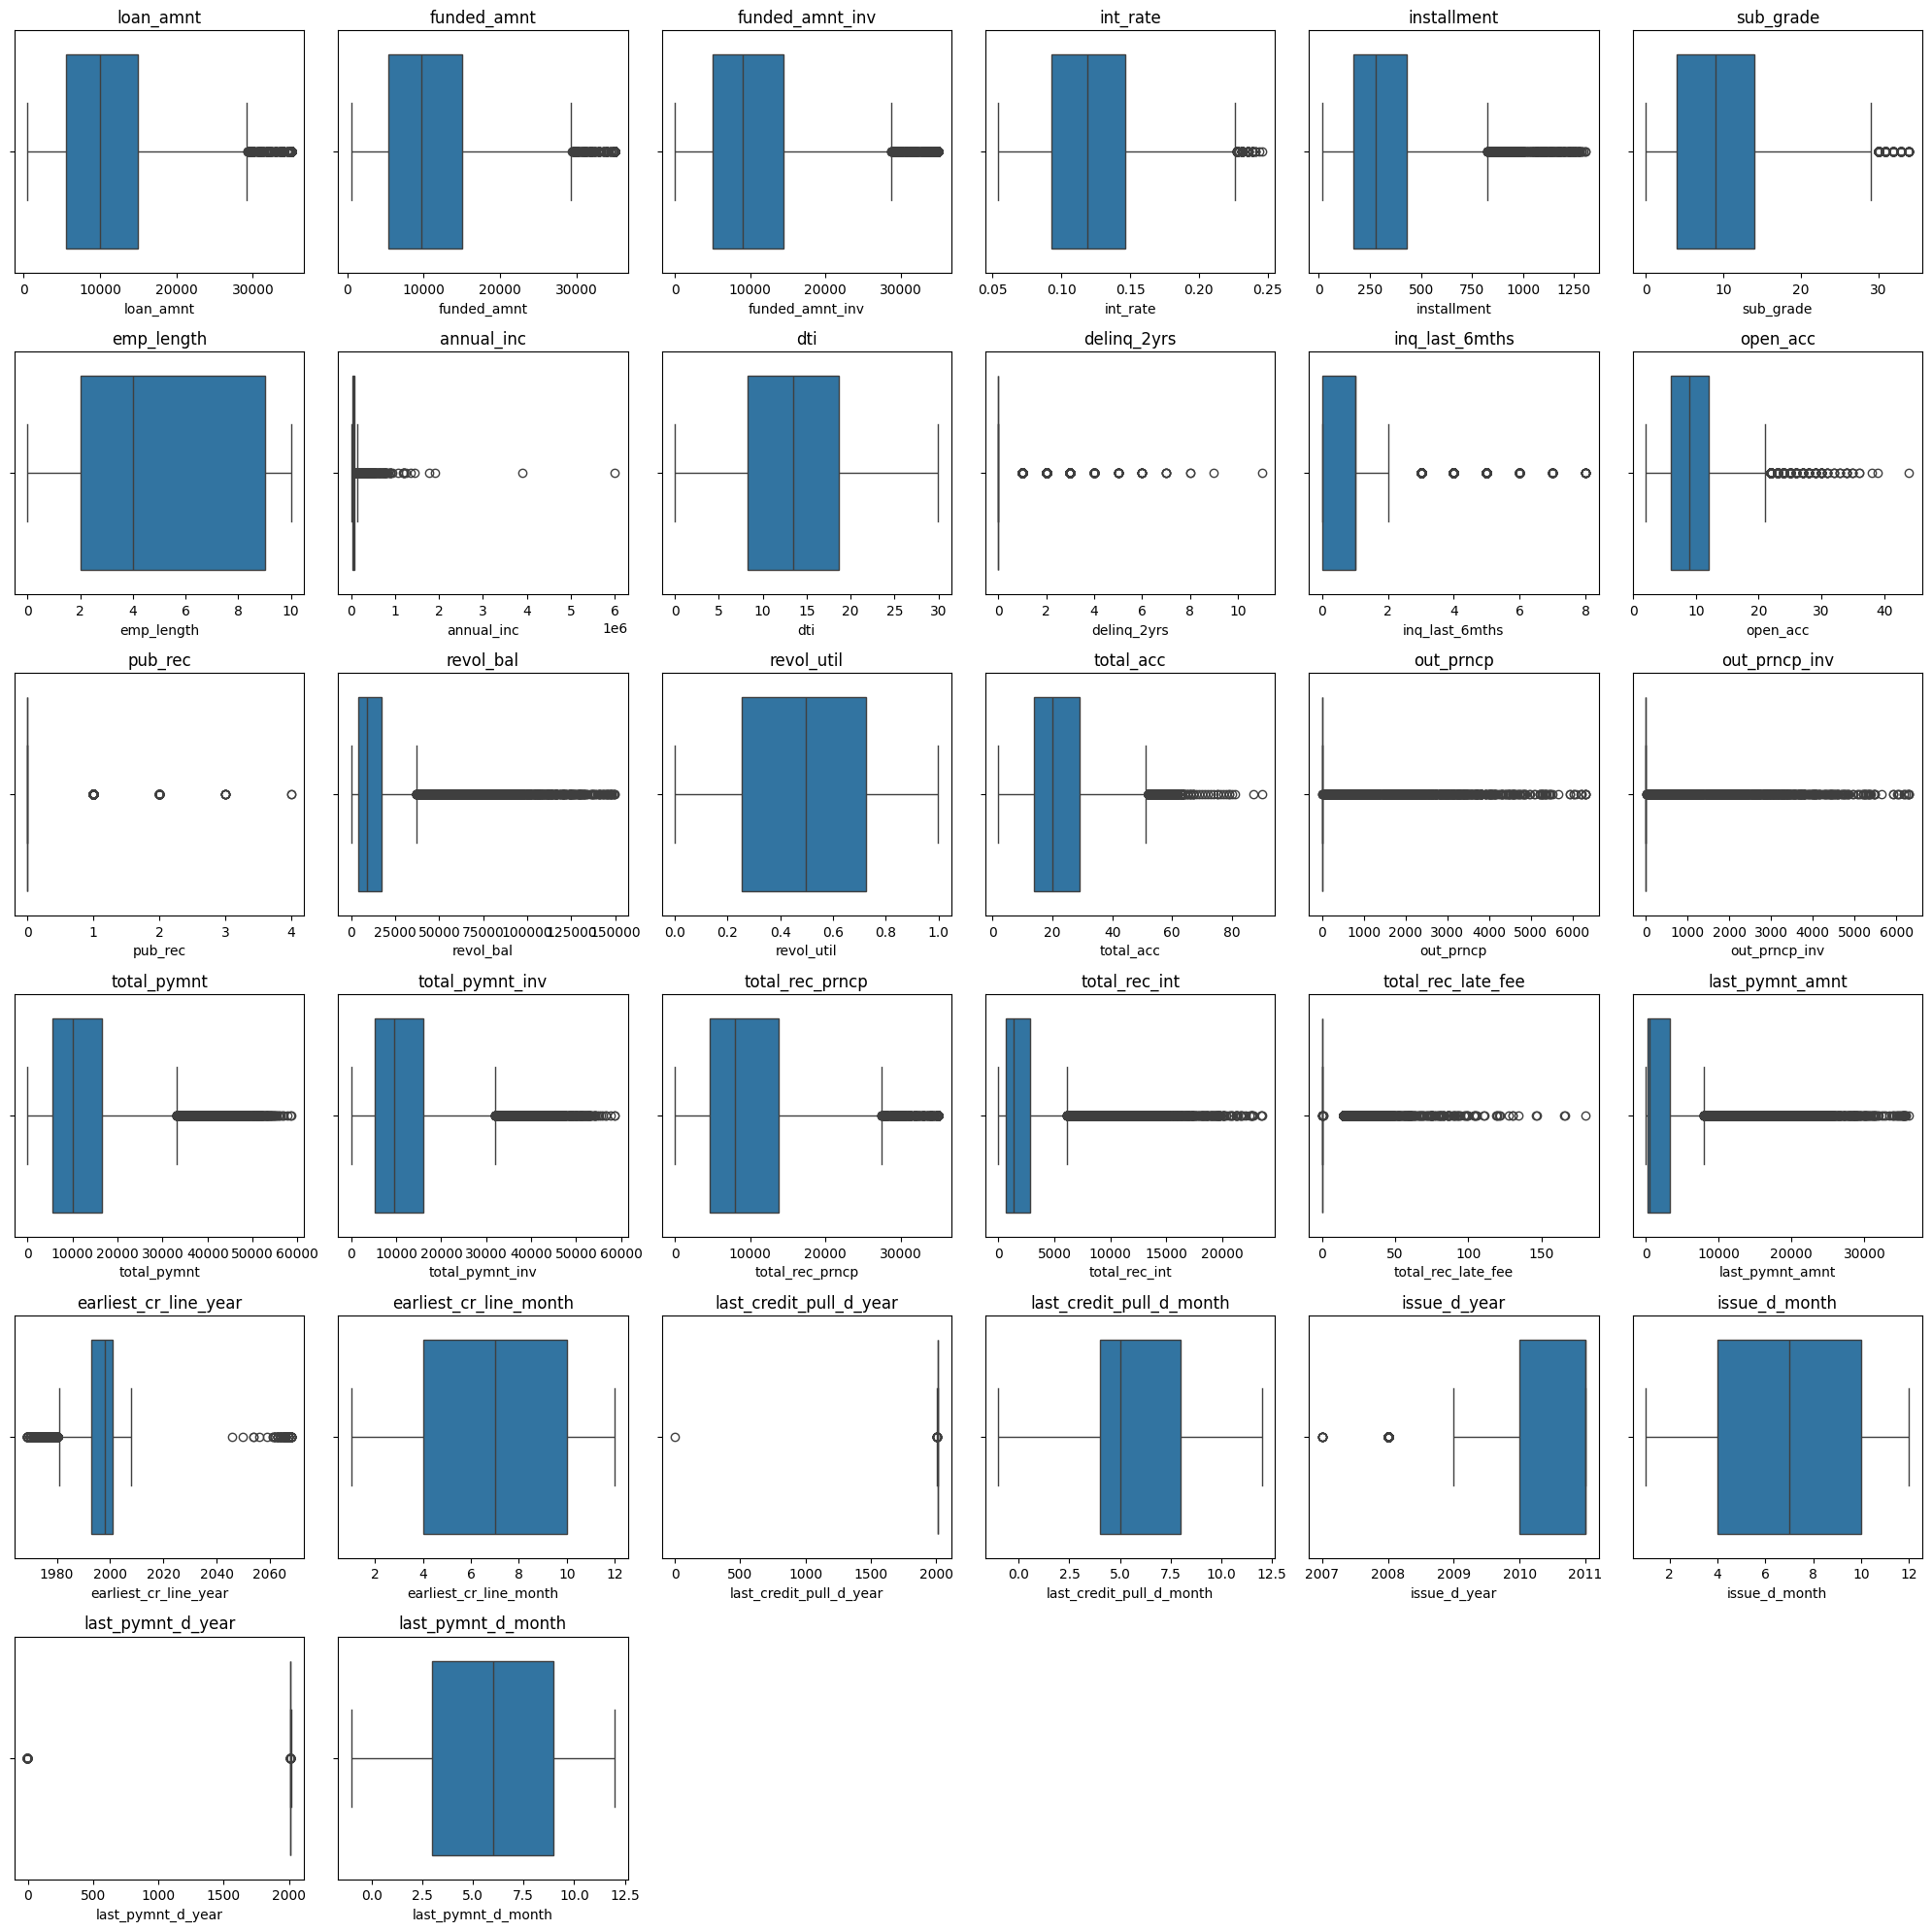

In [118]:
plot_distributions(data, num_cols, cols=6, figsize=(20, 20), kind='boxplot')

## Multivariate Analysis

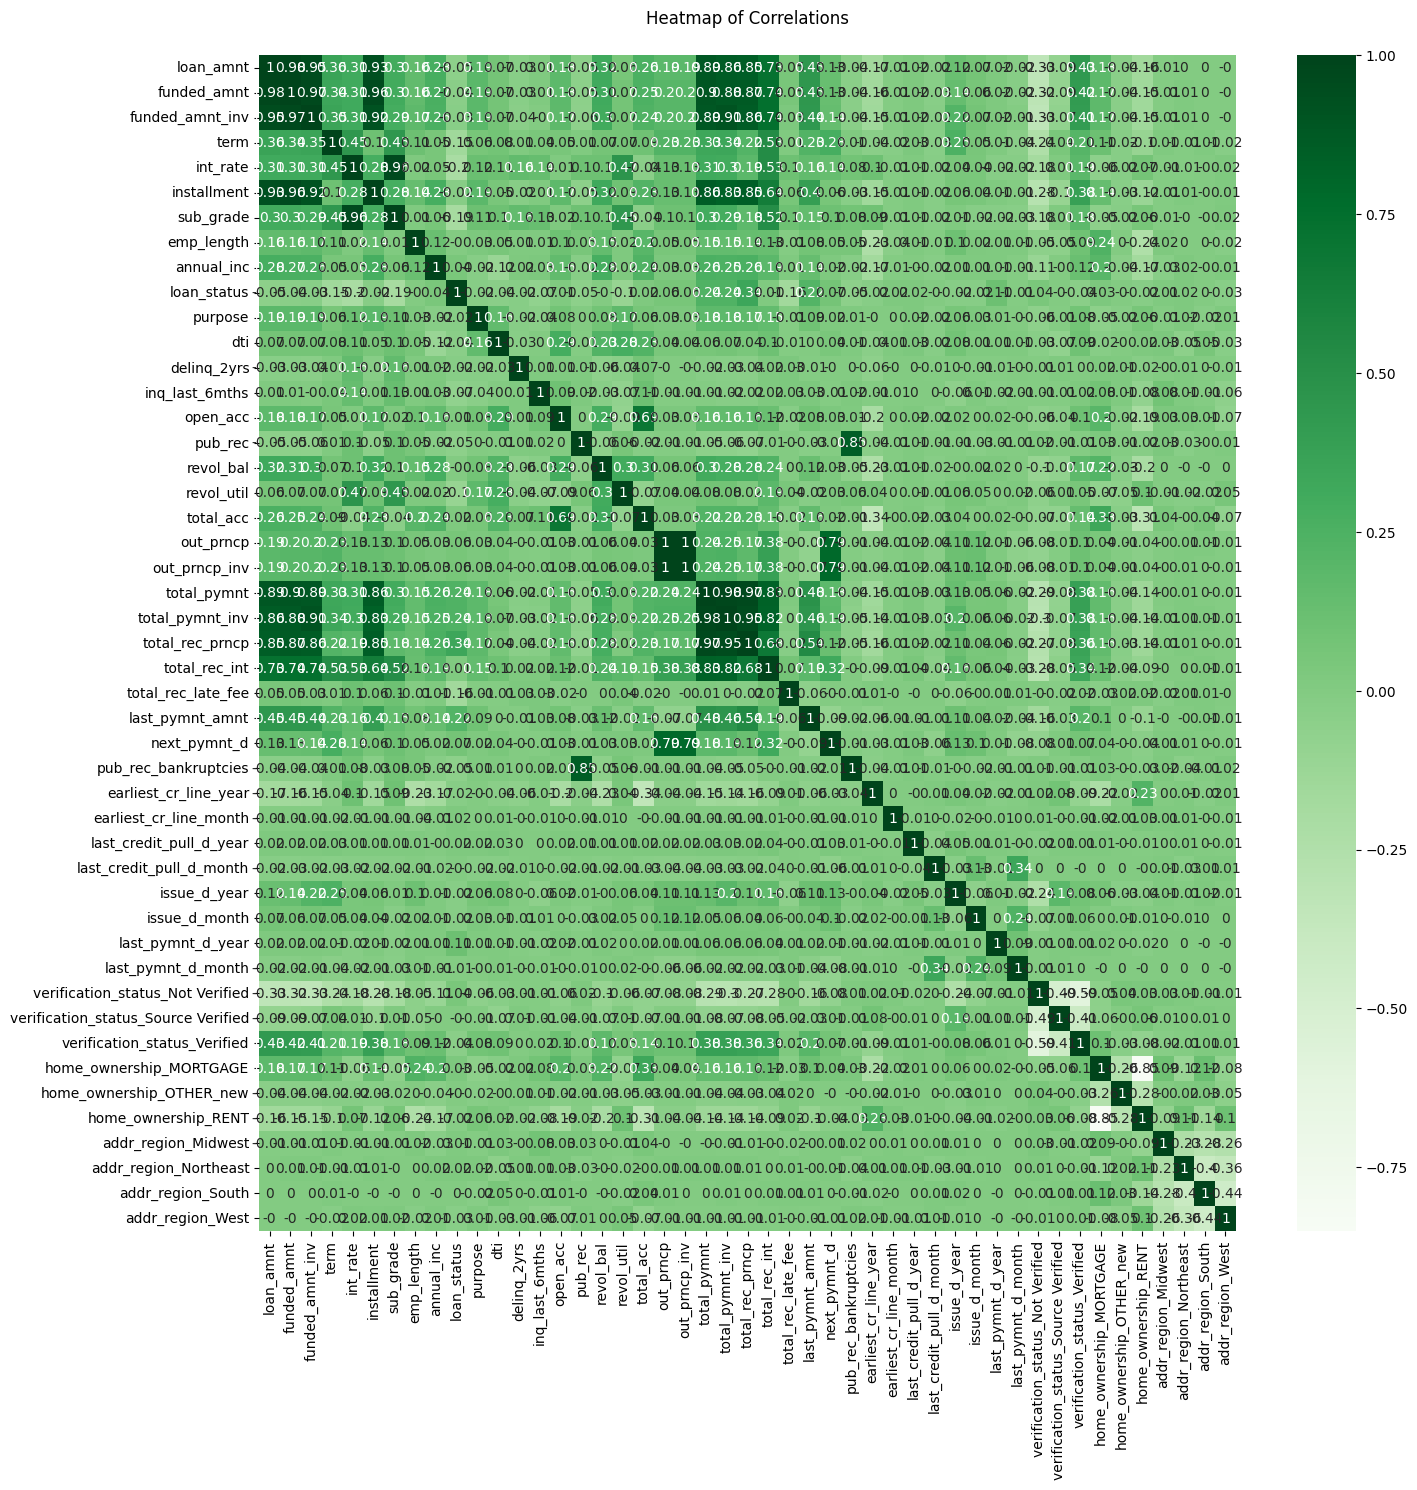

In [119]:
plt.figure(figsize=(15,15))
sns.heatmap(round(data.corr(),2), cmap='Greens', annot=True)
plt.title('Heatmap of Correlations', y=1.02)
plt.tight_layout()
plt.show() 

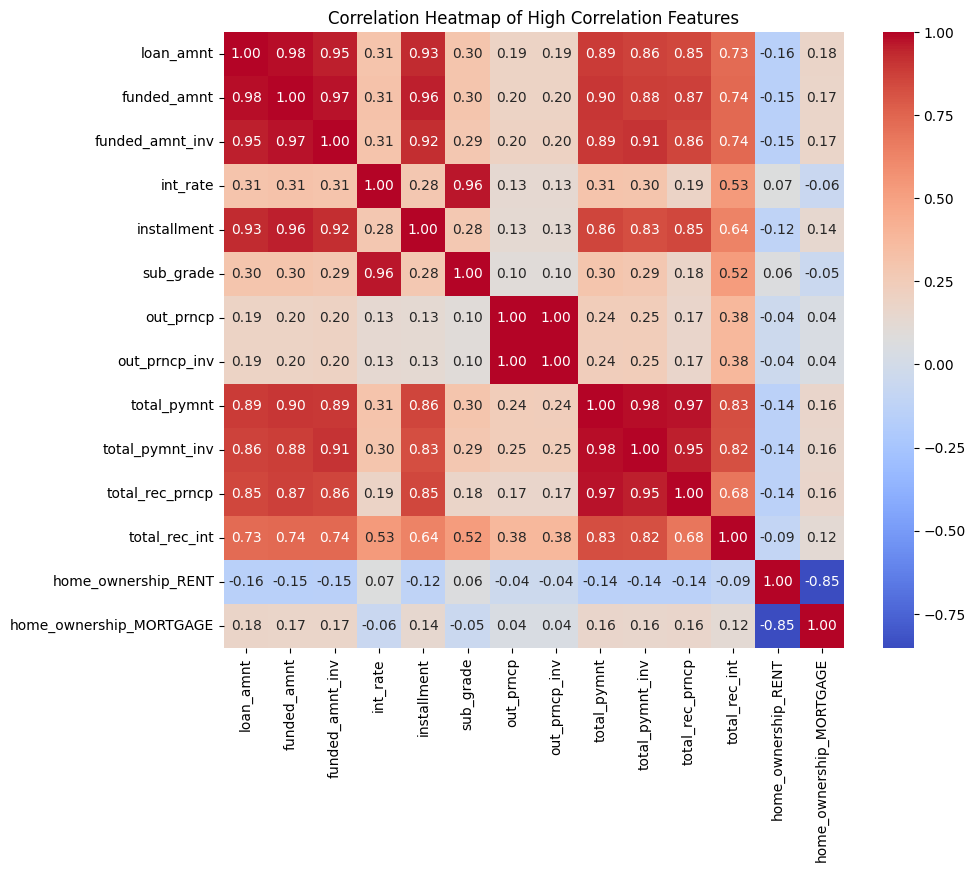

In [120]:
high_corr_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'sub_grade',
                      'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'home_ownership_RENT', 'home_ownership_MORTGAGE']
correlation_matrix = numeric_df[high_corr_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of High Correlation Features')
plt.show()

**Observations**

Many features in the dataset exhibit relatively high correlations with one another — for example, `loan_amnt` is strongly correlated with `funded_amnt`, and `funded_amnt` with `funded_amnt_inv`. While such multicollinearity can affect the interpretability of linear models like Logistic Regression, it typically does not degrade predictive performance in most machine learning algorithms.

Therefore, we will initially proceed with model training and evaluation without removing correlated features. Based on the model's performance and behavior, we will later determine whether it is necessary or beneficial to address these correlations.

# Build model and develop

## Building base line models for comparision

### Prepare data

In [121]:
data_train = data.copy()

def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    # Todo: Split data into X and y (using sklearn train_test_split). Return two dataframes
    y = df['loan_status'] # Todo: Select label
    X = df.drop(columns=['loan_status'])# Todo: Select features
    
    return X, y

X, y = prepare_X_y(data_train)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split( X_train,y_train, test_size=0.2, random_state=42)
print(f" X_train shape: {X_train.shape}, X_test shape: {X_test.shape},X_valid shape: {X_valid.shape}\n")
print(f" y_train shape: {y_train.shape}, y_test shape: {y_test.shape},y_valid shape: {y_valid.shape} \n")

 X_train shape: (24940, 46), X_test shape: (7794, 46),X_valid shape: (6236, 46)

 y_train shape: (24940,), y_test shape: (7794,),y_valid shape: (6236,) 



### Build Sk-learn models

In [123]:
def evaluate_model(y_test, y_pred, name):
    print(f"AUC-ROC Score {name}:", round(roc_auc_score(y_test, y_pred),3))
    print(f"Classification Report {name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix {name}:\n")
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Reject', 'Accept'],
                yticklabels=['Reject', 'Accept'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

**Logisticc Regression**

Model training completed in 34.20 seconds.
AUC-ROC Score Logistic Regression: 0.901
Classification Report Logistic Regression:

              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1130
           1       0.97      1.00      0.98      6664

    accuracy                           0.97      7794
   macro avg       0.98      0.90      0.93      7794
weighted avg       0.97      0.97      0.97      7794

Confusion Matrix Logistic Regression:



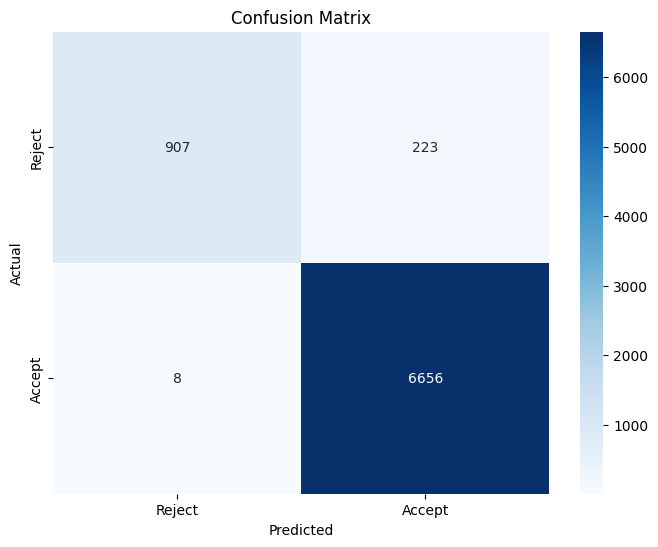

In [124]:
def build_model_logistic(X, y, use_scaler=True):
    start_time = time.time()
    if use_scaler:
        model = make_pipeline(StandardScaler(), LogisticRegression(solver='saga', max_iter=10000))
    else:
        model = LogisticRegression(solver='saga', max_iter=10000)
    model.fit(X, y)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model training completed in {elapsed_time:.2f} seconds.")
    return model, elapsed_time

model, lr_train_time = build_model_logistic(X_train, y_train, use_scaler=False)
y_pred_lr = model.predict(X_test)
evaluate_model(y_test, y_pred_lr, name='Logistic Regression')



**Decision Tree**

Model training completed in 0.40 seconds.
AUC-ROC Score Decision Tree Classifier: 0.969
Classification Report Decision Tree Classifier:

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1130
           1       0.99      0.99      0.99      6664

    accuracy                           0.99      7794
   macro avg       0.97      0.97      0.97      7794
weighted avg       0.99      0.99      0.99      7794

Confusion Matrix Decision Tree Classifier:



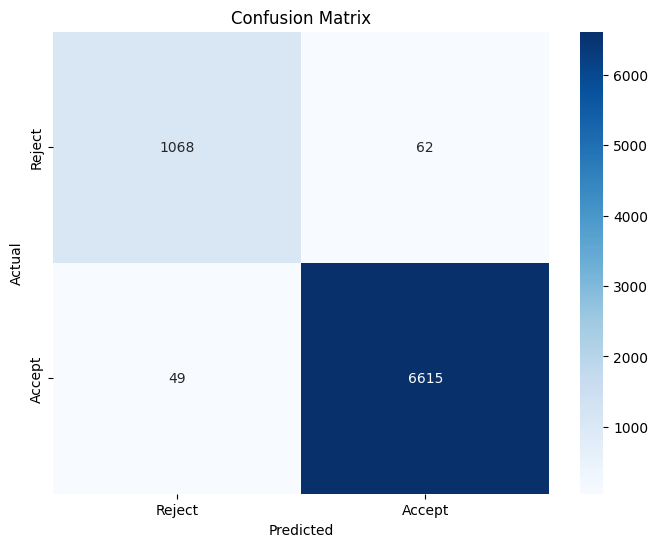

In [125]:
def build_model_decision_tree(X, y, use_scaler = True):
    start_time = time.time()
    if use_scaler:
        model = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=42))
    else:
        model = DecisionTreeClassifier(random_state=42)
    model.fit(X, y)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model training completed in {elapsed_time:.2f} seconds.")
    return model,elapsed_time
model,dt_train_time = build_model_decision_tree(X_train, y_train, use_scaler=False)
y_pred_dt = model.predict(X_test)
evaluate_model(y_test, y_pred_dt, name='Decision Tree Classifier')

**Gradient Boosting**

In [126]:
def build_modellightgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features=None, use_scaler=True):
    X_train_gbm = X_train.copy()
    X_valid_gbm = X_valid.copy()
    X_test_gbm = X_test.copy()

    summary = column_summary(numeric_df, cat_th=5, car_th=10)
    cat_cols = summary['categorical_cols']
    categorical_features = cat_cols.copy()
    categorical_features.append('emp_length')


    for col in categorical_features:
        X_train_gbm[col] = X_train_gbm[col].astype('category')
        X_valid_gbm[col] = X_valid_gbm[col].astype('category')
        X_test_gbm[col] = X_test_gbm[col].astype('category')

    lgb_train = lgb.Dataset(X_train_gbm, y_train, categorical_feature=categorical_features, free_raw_data=False)
    lgb_valid = lgb.Dataset(X_valid_gbm, y_valid, categorical_feature=categorical_features, reference=lgb_train)

    params = {
        "objective": "binary",
        "num_iterations": 3000,
        "metric": ["auc", "binary_logloss"],
        "boosting_type": "gbdt",
        "learning_rate": 0.05,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 4,
        "max_depth": 4,
        "num_threads": 4,
        "tree_learner": "serial",
        "early_stopping_round": 200,
        "verbose": -1,
        "feature_pre_filter": False,
        "first_metric_only": True,
        "is_unbalance": True,
    }

    start_time = time.time()
    if use_scaler:
        model = make_pipeline(StandardScaler(), lgb.train(
            params,
            train_set=lgb_train,
            valid_sets=[lgb_train, lgb_valid],
            callbacks=[
                lgb.early_stopping(100, first_metric_only=True),
                lgb.log_evaluation(50, show_stdv=True)
            ]
        ))
    else:
        model = lgb.train(
            params,
            train_set=lgb_train,
            valid_sets=[lgb_train, lgb_valid],
            callbacks=[
                lgb.early_stopping(100, first_metric_only=True),
                lgb.log_evaluation(50, show_stdv=True)
            ]
        )
    elapsed_time = time.time() - start_time
    print(f"Model training completed in {elapsed_time:.2f} seconds.")
    return model, X_test_gbm, elapsed_time
model,X_test_gbm, gbm_train_time = build_modellightgbm(X_train, y_train, X_valid, y_valid, X_test, use_scaler=False)
# Predict and evaluate the model
y_pred = model.predict(X_test_gbm)
y_pred_gbm = (y_pred > 0.5).astype(int)

# of Categorical Columns: 0 (Numerical but categorical: 14)
# of Numerical Columns: 32
# of Categorical but Cardinal Columns: 0

Categorical Columns: []
Numerical but Categorical Columns: ['term', 'purpose', 'next_pymnt_d', 'pub_rec_bankruptcies', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'home_ownership_MORTGAGE', 'home_ownership_OTHER_new', 'home_ownership_RENT', 'addr_region_Midwest', 'addr_region_Northeast', 'addr_region_South', 'addr_region_West']
Numerical Columns: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt', 'earliest_cr_line_year', 'earliest_cr_line_month', 'last_credit_pull_d_year', 'last_credit_pull_d_m

AUC-ROC Score Gradient Boosting/LightGBM: 0.992
Classification Report Gradient Boosting/LightGBM:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1130
           1       1.00      1.00      1.00      6664

    accuracy                           1.00      7794
   macro avg       1.00      0.99      0.99      7794
weighted avg       1.00      1.00      1.00      7794

Confusion Matrix Gradient Boosting/LightGBM:



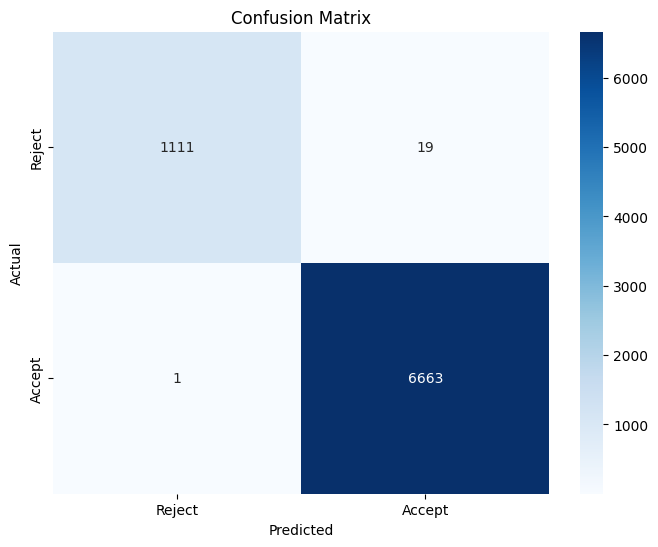

In [127]:
evaluate_model(y_test, y_pred_gbm, name='Gradient Boosting/LightGBM')

**Comparison**

In [129]:
metrics = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_gbm),
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_dt),
        roc_auc_score(y_test, y_pred_gbm),
    ],
    'Train Time': [
        lr_train_time,
        dt_train_time,
        gbm_train_time,
    ],
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0  Logistic Regression  0.970362   0.971015  0.970362  0.969039  0.900727   
1        Decision Tree  0.985758   0.985701  0.985758  0.985724  0.968890   
2    Gradient Boosting  0.997434   0.997438  0.997434  0.997425  0.991518   

   Train Time  
0   34.203794  
1    0.398294  
2    2.270707  
